In [1]:
import time
import klepto
import shelve
import pickle
import h5py
import numpy as np
import scipy.io as sio
from scipy.sparse import *
import matplotlib.pyplot as plt

c:\users\zzhno\anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load

In [2]:
dataset = '20m'
number = 8

- load train_list & test_list

In [3]:
feature=h5py.File('movielens/' + dataset + '/test_list.mat')  
test_list = feature['test_list'][:]
test_list = list(map(int, test_list.T[0]))
test_list = [i-1 for i in test_list] 
feature=h5py.File('movielens/' + dataset + '/train_list.mat')  
train_list = feature['train_list'][:]
train_list = list(map(int, train_list.T[0]))
train_list = [i-1 for i in train_list] 

In [4]:
feature.close()

- load full sparse matrix

In [5]:
rating_matrix = load_npz('movielens/sparse_matrix_ml-' + dataset + '_selected.npz').tocsc()
rating_matrix_train = rating_matrix[:, train_list]
rating_matrix_test  = rating_matrix[:, test_list]
print("file load DONE")

file load DONE


- return sorted matrix

In [6]:
# ratingNum_list = (rating_matrix.sum(axis=1).T.tolist()[0])
# index = sorted(range(len(ratingNum_list)), key=lambda k: ratingNum_list[k])
# rating_matrix = rating_matrix[index,:]

- load tree file: lr_bound & tree

In [7]:
with h5py.File('treeFile/lr_bound.mat') as data:
    lr_bound_list = [data[element[0]][:] for element in data['lr_bound']]

i = 0
for i in range(len(lr_bound_list)):
    level = lr_bound_list[i]
    lr_bound_list[i] = []
    level = list((level.T)[0])
    for boundNum in range(0, len(level), 2):
        lr_bound_list[i].append([int(level[boundNum]) - 1, int(level[boundNum + 1]) - 1])
    i += 1

lr_bound = {}
for i in range(len(lr_bound_list)):
    lr_bound[str(i)] = lr_bound_list[i]
    
depth_threshold = len(lr_bound_list)

In [8]:
feature=h5py.File('treeFile/tree.mat')  
tree = list(feature['tree'][:].T[0])
tree = [i-1 for i in tree]

In [9]:
feature.close()

## MF part

In [10]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.mllib.recommendation import ALS

class MatrixFactorization:
    def __init__(self, maxIter=15, regParam=0.01, rank=10):
        self.maxIter = maxIter
        self.regParam = regParam
        self.rank = rank
        conf = SparkConf().setAppName("appName").setMaster("local[*]")
        conf.set("spark.driver.memory","14g")
        conf.set("spark.executor.memory","14g")       
        self.spark = SparkContext(conf=conf)            
        print("New SparkSession started...")

    def change_parameter(self, regParam):
        self.regParam = regParam

    def matrix_factorization(self, train_lst):
        ratings = self.spark.parallelize(train_lst)
        model = ALS.train(ratings, self.rank, seed=10, \
                          iterations=self.maxIter, \
                          lambda_=self.regParam)
        print("MF DONE")
        productFeatures = sorted(model.userFeatures().collect(), key=lambda d: d[0], reverse=False)
        userFeatures = sorted(model.productFeatures().collect(), key=lambda d: d[0], reverse=False)
        itemProfile = {each[0]: each[1].tolist() for each in productFeatures}
        userProfile = {each[0]: each[1].tolist() for each in userFeatures}
             
        return userProfile, itemProfile

    def end(self):
        self.spark.stop()
        print("SparkSession stopped.")

In [11]:
lambda_list = [0.005, 0.01, 0.03, 0.05, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20]

prediction_model = {}
rmst_dict = {"0":[],"1":[],"2":[],"3":[],"4":[],"5":[],"6":[],"7":[],"8":[],"9":[],"10":[]}

In [15]:
MF = MatrixFactorization()

New SparkSession started...


level: 5
Rating Number of level 5: 6973561
Current plambda: 0.08
MF DONE
Current RMSE: 0.8951653684923568
--------------------------------
Current plambda: 0.09
MF DONE
Current RMSE: 0.89433473333431
--------------------------------
Current plambda: 0.1
MF DONE
Current RMSE: 0.8943459824831129
--------------------------------
min RMSE: 0.89433473333431


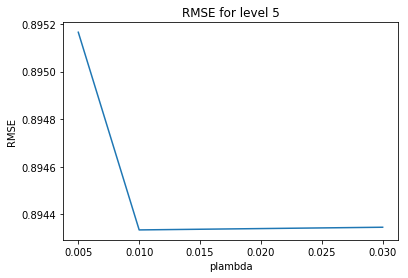

read: 532.861415 s


In [16]:
start = time.clock()
for level in range(depth_threshold):
#     if level < 4 or level > 6:
#         continue
# #     if level < 7:
# #         continue
    if level != 5:
        continue
#     if level < 3 or level > 6:
#         continue
    with h5py.File('treeFile/targetNode_' + str(level + 1) + '.mat') as data:
        targetNode = [data[element[0]][:] for element in data['targetNode']]
    with h5py.File('treeFile/rated_user_' + str(level + 1) + '.mat') as data:
        rated_users = [data[element[0]][:] for element in data['rated_user']]          
    level = str(level)
    print("level:", level)    
                   
    prediction_model.setdefault(level, {})
    train_lst = []    
    
    for pseudo_item_bound, itemid in zip(lr_bound[level], range(len(lr_bound[level]))):
        if pseudo_item_bound[0] > pseudo_item_bound[1]:
            continue
        pseudo_item_lst = tree[pseudo_item_bound[0]:(pseudo_item_bound[1] + 1)]
        pseudo_matrix = np.array(rating_matrix_train[:, pseudo_item_lst].sum(axis=1))[:,0] / \
                                     (rating_matrix_train[:, pseudo_item_lst].getnnz(axis=1)+1e-9)
        train_lst += [(itemid, userid, float(pseudo_matrix[userid])) \
                      for userid in range(pseudo_matrix.shape[0]) if pseudo_matrix[userid]]        

    print("Rating Number of level " + level + ": " + str(len(train_lst)))
    
    #### Train MF and Do validation ####
    min_RMSE = -1
    user_profile_list = []
    item_profile_list = []
    for plambda in lambda_list:
        #20m
        if int(level) >= 4 and plambda < 0.08:
            continue
        if int(level) >= 2 and plambda < 0.06:
            continue
        if plambda < 0.08:
            continue
#         #1m    
#         if int(level) >= 1 and plambda < 0.05:
#             continue
        print("Current plambda: " + str(plambda))
        MF.change_parameter(plambda)
        user_profile, item_profile = MF.matrix_factorization(train_lst)
        prediction_model[level]['ipro'] = item_profile
        user_profile_list.append(user_profile)
        item_profile_list.append(item_profile)
        
        P = np.dot(np.array(list(user_profile.values())), np.array(list(item_profile.values())).T)            
        P_test = np.zeros(rating_matrix_test.shape)
        rating_matrix_test_unqueried = rating_matrix_test.toarray()
        for itemid in range(rating_matrix_test.shape[1]):
#             if itemid  % 2000 == 0:
#                 print("%.2f%%" % (100 * itemid / rating_matrix_test.shape[1]))      
            pred_index = int(targetNode[itemid].T[0][1]) - 1
            final_level = int(targetNode[itemid].T[0][0]) - 1
            if rated_users[itemid].sum() == 0 or np.sum(rated_users[itemid] == [1, 0]):
                rated_user = []
            else:
                rated_user = [int(i-1) for i in list((rated_users[itemid]).T[0])]
            
            pred_index = list(prediction_model[str(final_level)]['ipro'].keys()).index(pred_index)
            P_test[:, itemid] = P[:, pred_index]
            rating_matrix_test_unqueried[rated_user, itemid] = 0

        rating_matrix_test_unqueried = csc_matrix(rating_matrix_test_unqueried)
        P_test = (rating_matrix_test_unqueried!=0).multiply(P_test)
        
        P_test = P_test.tolil()
        P_test[P_test>5] = 5
        P_test[P_test<0] = 0
        
        dif = P_test - rating_matrix_test_unqueried
        RMSE = ( dif.multiply(dif).sum() / (rating_matrix_test_unqueried!=0).sum() )**0.5
        print("Current RMSE: " + str(RMSE))
        print("--------------------------------")
        rmst_dict[level].append(RMSE)
        ## if RMSE goes up, stop test for this level
        if len(rmst_dict[level]) - 1 != 0 and rmst_dict[level][len(rmst_dict[level]) - 1] > rmst_dict[level][len(rmst_dict[level]) - 2]:
            break        
        
    min_MF = rmst_dict[level].index(min(rmst_dict[level]))   
    prediction_model[level]['upro'] = user_profile_list[min_MF]
    prediction_model[level]['ipro'] = item_profile_list[min_MF]
    prediction_model[level]['plambda'] = lambda_list[min_MF]
    print("min RMSE: " + str(min(rmst_dict[level])))
    
    plt.figure(1)
    plt.title('RMSE for level ' + level)
    plt.xlabel('plambda')
    plt.ylabel('RMSE')
    plt.plot(lambda_list[0:len(rmst_dict[level])], rmst_dict[level])
    plt.show()


end = time.clock()
print("read: %f s" % (end - start))

In [14]:
MF.end()

SparkSession stopped.


### In case Spark fails halfway

In [ ]:
rmst_dict["3"] = []
prediction_model["3"]={}

In [16]:
with shelve.open("treeFile/prediction_model", protocol=pickle.HIGHEST_PROTOCOL) as d:
    d['content'] = prediction_model
with shelve.open("treeFile/rmst_dict", protocol=pickle.HIGHEST_PROTOCOL) as d:
    d['content'] = rmst_dict

In [14]:
with shelve.open("treeFile/prediction_model", protocol=pickle.HIGHEST_PROTOCOL) as d:
    prediction_model = d['content']
with shelve.open("treeFile/rmst_dict", protocol=pickle.HIGHEST_PROTOCOL) as d:
    rmst_dict = d['content']

### Save results

In [ ]:
import klepto
Tree = klepto.archives.dir_archive('treeFile', cached=True, serialized=True)
Tree['prediction_model_20m_' + str(number)] = prediction_model
Tree.dump()
Tree.clear()

In [15]:
min_rmse_list = []
for i in range(3,7):
    min_rmse_list.append(min(rmst_dict[str(i)]))

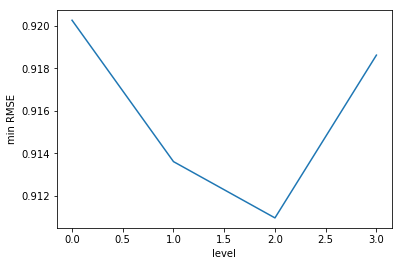

In [16]:
plt.figure(1)
plt.xlabel('level')
plt.ylabel('min RMSE')
plt.plot(list(range(4)), min_rmse_list)
plt.show()

In [ ]:
# for i in range(depth_threshold - 1):
#     sio.savemat('rmse_list' + str(i) + '.mat', {'rmse_list': rmst_dict[str(i)]})

sio.savemat('min_rmse_list_' + str(number) + '.mat', {'min_rmse_list':min_rmse_list})

### Prediction for multiple trees

In [44]:
number = 10

In [45]:
import klepto
Tree = klepto.archives.dir_archive('treeFile', {}, serialized=True)
Tree.load()
prediction_model = Tree['prediction_model_20m_' + str(number)]

In [46]:
level = 5

with h5py.File('treeFile/targetNode_' + str(level + 1) + '.mat') as data:
    targetNode = [data[element[0]][:] for element in data['targetNode']]
with h5py.File('treeFile/rated_user_' + str(level + 1) + '.mat') as data:
    rated_users = [data[element[0]][:] for element in data['rated_user']]

level = str(level)
print("level:", level)    
P = np.dot(np.array(list(prediction_model[level]['upro'].values())), np.array(list(prediction_model[level]['ipro'].values())).T)
P_test = np.zeros(rating_matrix_test.shape)
rated_matrix = np.zeros(rating_matrix_test.shape)
rating_matrix_test_unqueried = rating_matrix_test.toarray()
for itemid in range(rating_matrix_test.shape[1]):  
    pred_index = int(targetNode[itemid].T[0][1]) - 1
    final_level = int(targetNode[itemid].T[0][0]) - 1
    if rated_users[itemid].sum() == 0 or np.sum(rated_users[itemid] == [1, 0]):
        rated_user = []
    else:
        rated_user = [int(i-1) for i in list((rated_users[itemid]).T[0])]

    P_test[:, itemid] = P[:, pred_index]
    rating_matrix_test_unqueried[rated_user, itemid] = 0
    rated_matrix[rated_user, itemid] = 1

rating_matrix_test_unqueried = csc_matrix(rating_matrix_test_unqueried)
P_test = (rating_matrix_test_unqueried!=0).multiply(P_test)
dif = P_test - rating_matrix_test_unqueried
RMSE = ( dif.multiply(dif).sum() / (rating_matrix_test_unqueried!=0).sum() )**0.5
print("Current RMSE: " + str(RMSE))
rated_matrix = rated_matrix==0

level: 5
Current RMSE: 0.889112766105476


In [47]:
with shelve.open("test_20m/" + str(number) + "/P_test", protocol=pickle.HIGHEST_PROTOCOL) as d:
    d['content'] = P_test
with shelve.open("test_20m/" + str(number) + "/rated_matrix", protocol=pickle.HIGHEST_PROTOCOL) as d:
    d['content'] = rated_matrix

### RMSE of Different ratings obtained

In [18]:
level = 5

with h5py.File('treeFile/targetNode_' + str(level + 1) + '.mat') as data:
    targetNode = [data[element[0]][:] for element in data['targetNode']]
with h5py.File('treeFile/rated_user_' + str(level + 1) + '.mat') as data:
    rated_users = [data[element[0]][:] for element in data['rated_user']]

level = str(level)
print("level:", level)    
P = np.dot(np.array(list(prediction_model[level]['upro'].values())), np.array(list(prediction_model[level]['ipro'].values())).T)
P_test = np.zeros(rating_matrix_test.shape)
rated_matrix = np.zeros(rating_matrix_test.shape)
rating_matrix_test_unqueried = rating_matrix_test.toarray()
for itemid in range(rating_matrix_test.shape[1]):  
    pred_index = int(targetNode[itemid].T[0][1]) - 1
    final_level = int(targetNode[itemid].T[0][0]) - 1
    if rated_users[itemid].sum() == 0 or np.sum(rated_users[itemid] == [1, 0]):
        rated_user = []
    else:
        rated_user = [int(i-1) for i in list((rated_users[itemid]).T[0])]
#     print(rated_users[itemid])
    P_test[:, itemid] = P[:, pred_index]
    rating_matrix_test_unqueried[rated_user, itemid] = 0
    rated_matrix[rated_user, itemid] = 1

rating_matrix_test_unqueried = csc_matrix(rating_matrix_test_unqueried)

P_test = (rating_matrix_test_unqueried!=0).multiply(P_test)
dif = P_test - rating_matrix_test_unqueried

level: 5


In [19]:
rated_number = rated_matrix.sum(axis=0)

In [20]:
rated_number_sorted = sorted(rated_number, reverse=True)
for zeroPos in range(len(rated_number_sorted)):
    if rated_number_sorted[zeroPos] == 0:
        break

In [21]:
rated_number_index = sorted(range(len(rated_number)), key=lambda k: rated_number[k])
rated_number_index.reverse()

In [39]:
rmse_list = []
interval_list = []

In [40]:
subsetNum = 8;

startPos = 0;
endPos = int(zeroPos / subsetNum);
for i in range(0, subsetNum):
    
    print(str(i) + 'th:')
    print("Start: " + str(startPos))
    print("End: " + str(endPos))
    print("Start Rating Number: " + str(rated_number[rated_number_index[startPos]]))
    print("End Rating Number: " + str(rated_number[rated_number_index[endPos]]))
    item_set = rated_number_index[startPos:endPos]
    RMSE = ( dif[:, item_set].multiply(dif[:, item_set]).sum() / (rating_matrix_test_unqueried[:, item_set]!=0).sum() )**0.5
    rmse_list.append(RMSE)
    interval_list.append((rated_number[rated_number_index[startPos]], rated_number[rated_number_index[endPos]]))
    print("Current RMSE: " + str(RMSE))

    startPos = endPos + 1;
#     if startPos>2988:
#         endPos = len(rated_number_index)
    if i == subsetNum - 1:   
        endPos = len(rated_number_index)
    else:
        endPos = endPos + int(zeroPos  / subsetNum);

0th:
Start: 0
End: 404
Start Rating Number: 508.0
End Rating Number: 52.0
Current RMSE: 0.87035870983
1th:
Start: 405
End: 808
Start Rating Number: 52.0
End Rating Number: 23.0
Current RMSE: 0.874766174811
2th:
Start: 809
End: 1212
Start Rating Number: 23.0
End Rating Number: 12.0
Current RMSE: 0.885536687708
3th:
Start: 1213
End: 1616
Start Rating Number: 12.0
End Rating Number: 6.0
Current RMSE: 0.90327066476
4th:
Start: 1617
End: 2020
Start Rating Number: 6.0
End Rating Number: 3.0
Current RMSE: 0.92419338281
5th:
Start: 2021
End: 2424
Start Rating Number: 3.0
End Rating Number: 2.0
Current RMSE: 0.939945107362
6th:
Start: 2425
End: 2828
Start Rating Number: 2.0
End Rating Number: 1.0
Current RMSE: 0.941642125195
7th:
Start: 2829
End: 3232
Start Rating Number: 1.0
End Rating Number: 1.0
Current RMSE: 0.915319015086


In [43]:
startPos = 2829
endPos = len(rated_number_index) - 1
print("Start: " + str(startPos))
print("End: " + str(endPos))
print("Start Rating Number: " + str(rated_number[rated_number_index[startPos]]))
print("End Rating Number: " + str(rated_number[rated_number_index[endPos]]))
item_set = rated_number_index[startPos:endPos]
RMSE = ( dif[:, item_set].multiply(dif[:, item_set]).sum() / (rating_matrix_test_unqueried[:, item_set]!=0).sum() )**0.5
rmse_list[len(rmse_list) - 1]  = RMSE
interval_list[len(rmse_list) - 1]  = (rated_number[rated_number_index[startPos]], rated_number[rated_number_index[endPos]])
print("Current RMSE: " + str(RMSE))

Start: 2829
End: 7666
Start Rating Number: 1.0
End Rating Number: 0.0
Current RMSE: 0.947759209605


In [44]:
sio.savemat('rmse_list.mat', {'rmse_list':rmse_list})

In [45]:
sio.savemat('interval_list.mat', {'interval_list':interval_list})